# Using PyMC3

PyMC3 is a Python package for doing MCMC using a variety of samplers, including Metropolis, Slice and Hamiltonian Monte Carlo. See [Probabilistic Programming in Python using PyMC](http://arxiv.org/abs/1507.08050) for a description. The GitHub [site](https://github.com/pymc-devs/pymc3) also has many examples and links for further exploration.

In [1]:
! pip install --quiet pymc3
! pip install --quiet daft
! pip install --quiet seaborn

In [2]:
! conda install --yes --quiet mkl-service

Fetching package metadata .........
Solving package specifications: ..........

# All requested packages already installed.
# packages in environment at /opt/conda:
#
mkl-service               1.1.2                    py35_3  


**Other resources**

Some examples are adapted from:

- [Probabilistic Programming & Bayesian Methods for Hackers](http://camdavidsonpilon.github.io/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/)
- [MCMC tutorial series](https://theclevermachine.wordpress.com/2012/11/19/a-gentle-introduction-to-markov-chain-monte-carlo-mcmc/)

In [3]:
%matplotlib inline

In [4]:
import numpy as np
import numpy.random as rng
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pymc3 as pm
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
import daft

In [5]:
import theano
theano.config.warn.round=False

## Example: Estimating coin bias

We start with the simplest model - that of determining the bias of a coin from observed outcomes.

### Setting up the model    

In [6]:
n = 100
heads = 61

#### Analytical solution

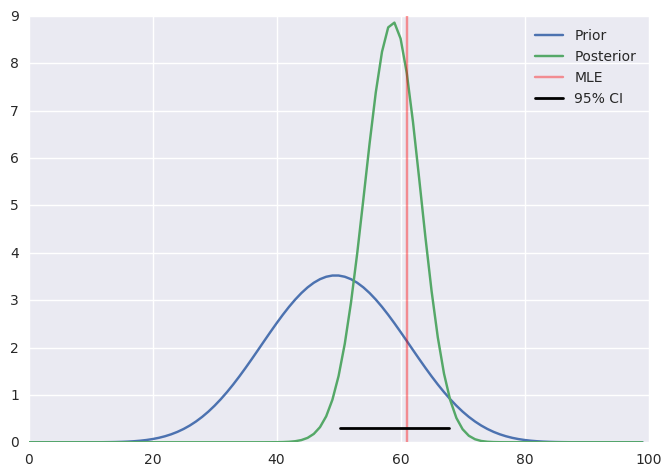

In [7]:
a, b = 10, 10
prior = stats.beta(a, b)
post = stats.beta(heads+a, n-heads+b)
ci = post.interval(0.95)

xs = np.linspace(0, 1, 100)
plt.plot(prior.pdf(xs), label='Prior')
plt.plot(post.pdf(xs), label='Posterior')
plt.axvline(100*heads/n, c='red', alpha=0.4, label='MLE')
plt.xlim([0, 100])
plt.axhline(0.3, ci[0], ci[1], c='black', linewidth=2, label='95% CI');
plt.legend()
pass

#### Graphical model

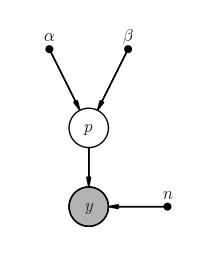

In [8]:
pgm = daft.PGM(shape=[2.5, 3.0], origin=[0, -0.5])

pgm.add_node(daft.Node("alpha", r"$\alpha$", 0.5, 2, fixed=True))
pgm.add_node(daft.Node("beta", r"$\beta$", 1.5, 2, fixed=True))
pgm.add_node(daft.Node("p", r"$p$", 1, 1))
pgm.add_node(daft.Node("n", r"$n$", 2, 0, fixed=True))
pgm.add_node(daft.Node("y", r"$y$", 1, 0, observed=True))

pgm.add_edge("alpha", "p")
pgm.add_edge("beta", "p")
pgm.add_edge("n", "y")
pgm.add_edge("p", "y")

pgm.render()
pass

## Introduction to PyMC3

In [9]:
niter = 2000
with pm.Model() as coin_context:
    p = pm.Beta('p', alpha=2, beta=2)
    y = pm.Binomial('y', n=n, p=p, observed=heads)
    trace = pm.sample(niter)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -4.2744: 100%|██████████| 200000/200000 [00:15<00:00, 12698.15it/s]
Finished [100%]: Average ELBO = -4.2693
100%|██████████| 2000/2000 [00:01<00:00, 1753.85it/s]


### Specifying start,  sampler (step) and multiple chains

In [10]:
with coin_context:
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace = pm.sample(niter, step=step, start=start, njobs=4, random_seed=123)

Optimization terminated successfully.
         Current function value: 3.582379
         Iterations: 3
         Function evaluations: 5
         Gradient evaluations: 5


100%|██████████| 2000/2000 [00:00<00:00, 5656.17it/s]


#### MAP estimate

In [11]:
start

{'p_logodds_': array(0.42956265615645184)}

### Summary of results

#### Discard 50% as burn-in

In [12]:
t = trace[niter//2:]
t['p'].shape

(4000,)

#### Getting values from the trace

In [13]:
p = trace.get_values('p', burn=niter//2, combine=True, chains=[0,2])
p.shape

(2000,)

#### Autocorrelation plot

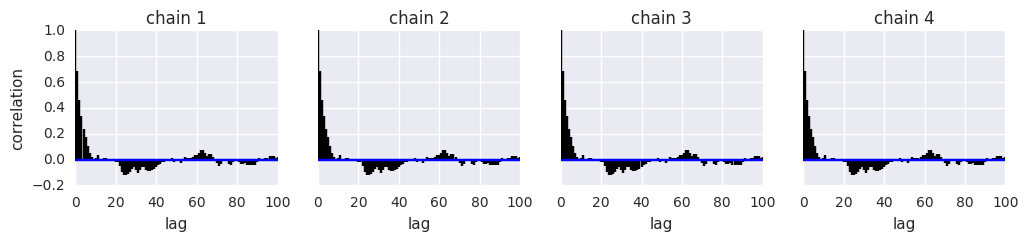

In [14]:
pm.autocorrplot(t, varnames=['p'])
pass

#### Calculate effective sample size

$$
\hat{n}_{eff} = \frac{mn}{1 + 2 \sum_{t=1}^T \hat{\rho}_t}
$$

where $m$ is the number of chains, $n$ the number of steps per chain, $T$ the time when the autocorrelation first becomes negative, and $\hat{\rho}_t$ the autocorrelation at lag $t$.

In [15]:
pm.effective_n(t)

{'p': 767.0, 'p_logodds_': 765.0}

## Evaluate convergence

##### Gelman-Rubin

$$
\hat{R} = \frac{\hat{V}}{W}
$$

where $W$ is the within-chain variance and $\hat{V}$ is the posterior variance estimate for the pooled traces.  Values greater than one indicate that one or more chains have not yet converged.

Discrad burn-in steps for each chain. The idea is to see if the starting values of each chain come from the same distribution as the stationary state. 

- $W$ is the number of chains $m \times$ the variacne of each individual chain
- $B$ is the number of steps $n \times$ the variance of the chain means
- $\hat{V}$ is the weigthed average $(1 - \frac{1}{n})W + \frac{1}{n}B$

The idea is that $\hat{V}$ is an unbiased estimator of $W$ if the starting values of each chain come from the same distribution as the stationary state. Hence if $\hat{R}$ differs significantly from 1, there is probsbly no convergence and we need more iterations. This is done for each parameter $\theta$.

In [16]:
pm.gelman_rubin(t)

{'p': 0.99949987493746084, 'p_logodds_': 0.99949987493746095}

##### Geweke

Compares mean of initial with later segments of a trace for a parameter. Should have absolute value less than 1 at convergence.

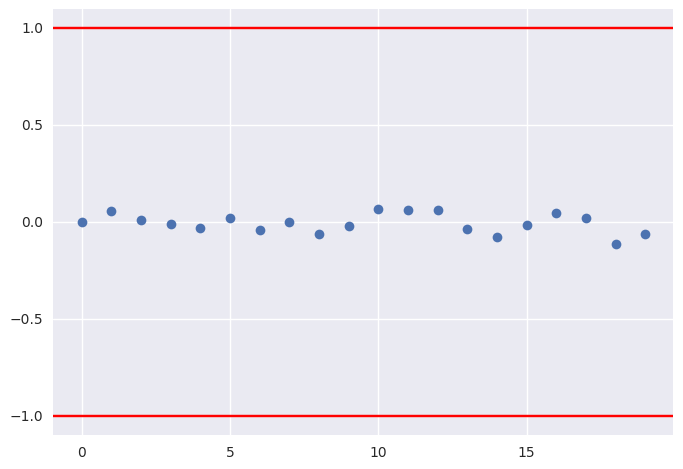

In [17]:
plt.plot(pm.geweke(t['p'])[:,1], 'o')
plt.axhline(1, c='red')
plt.axhline(-1, c='red')
plt.gca().margins(0.05)
pass

#### Textual summary

In [18]:
pm.summary(t, varnames=['p'])


p:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.615            0.050            0.002            [0.517, 0.698]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.517          0.581          0.616          0.654          0.698



#### Visual summary

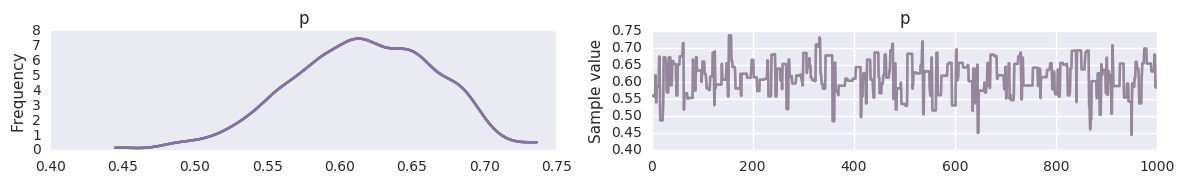

In [19]:
pm.traceplot(t, varnames=['p'])
pass

#### Posterior predictive samples

In [20]:
with coin_context:
    ppc = pm.sample_ppc(t, samples=100)
ppc['y'].ravel()

100%|██████████| 100/100 [00:00<00:00, 337.12it/s]


array([67, 70, 53, 66, 41, 56, 70, 60, 66, 46, 48, 63, 64, 58, 65, 55, 63,
       66, 67, 58, 70, 73, 69, 55, 51, 70, 58, 68, 59, 50, 60, 67, 59, 58,
       70, 56, 62, 63, 68, 65, 60, 64, 58, 44, 68, 75, 60, 55, 64, 66, 71,
       59, 62, 53, 62, 67, 65, 59, 56, 59, 62, 67, 61, 58, 79, 68, 54, 62,
       71, 60, 66, 57, 67, 70, 47, 58, 69, 68, 62, 67, 49, 61, 66, 40, 57,
       65, 53, 40, 67, 65, 55, 53, 70, 61, 57, 51, 66, 68, 68, 73])

## Saving traces

##### CSV

In [21]:
from pymc3.backends import Text

niter = 2000
with pm.Model() as text_save_demo:
    p = pm.Beta('p', alpha=2, beta=2)
    y = pm.Binomial('y', n=n, p=p, observed=heads)
    db = Text('trace')
    trace = pm.sample(niter, trace=db)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -4.2758: 100%|██████████| 200000/200000 [00:16<00:00, 12263.44it/s]
Finished [100%]: Average ELBO = -4.2726
100%|██████████| 2000/2000 [00:01<00:00, 1655.80it/s]


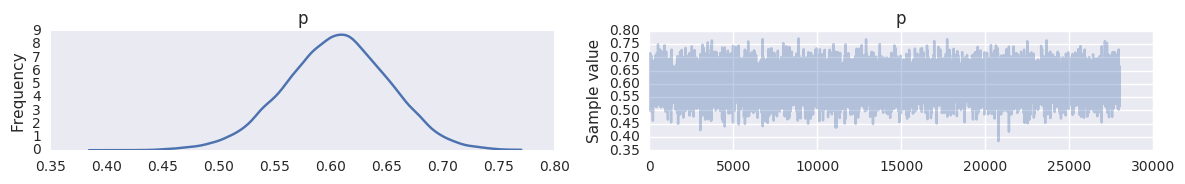

In [22]:
with text_save_demo:
    trace = pm.backends.text.load('trace')
    pm.traceplot(trace, varnames=['p'])

In [23]:
trace.varnames

['p_logodds_', 'p']

##### SQLite

If you are fitting a large complex model that may not fit in memory, you can use the SQLite3 backend to save the trace incremnetally to disk.

In [24]:
from pymc3.backends import SQLite

niter = 2000
with pm.Model() as sqlie3_save_demo:
    p = pm.Beta('p', alpha=2, beta=2)
    y = pm.Binomial('y', n=n, p=p, observed=heads)
    db = SQLite('trace.db')
    trace = pm.sample(niter, trace=db)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -4.2776: 100%|██████████| 200000/200000 [00:17<00:00, 11746.28it/s]
Finished [100%]: Average ELBO = -4.2749
100%|██████████| 2000/2000 [00:01<00:00, 1496.41it/s]


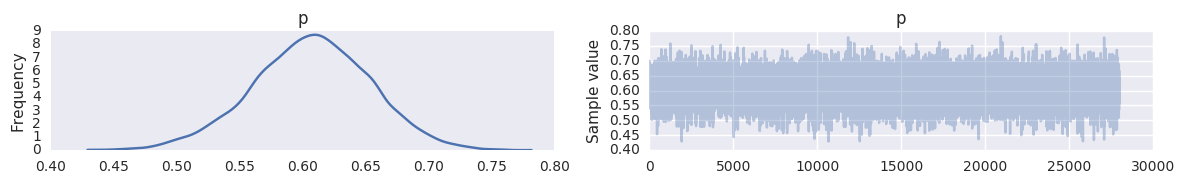

In [25]:
with sqlie3_save_demo:
    trace = pm.backends.sqlite.load('trace.db')
    pm.traceplot(trace, varnames=['p'])

## Sampling from prior

Just omit the `observed=` argument.

In [26]:
with pm.Model() as prior_context:
    sigma = pm.Gamma('sigma', alpha=2.0, beta=1.0)
    mu = pm.Normal('mu', mu=0, sd=sigma)
    trace = pm.sample(niter, step=pm.Metropolis())

100%|██████████| 2000/2000 [00:00<00:00, 4522.74it/s]


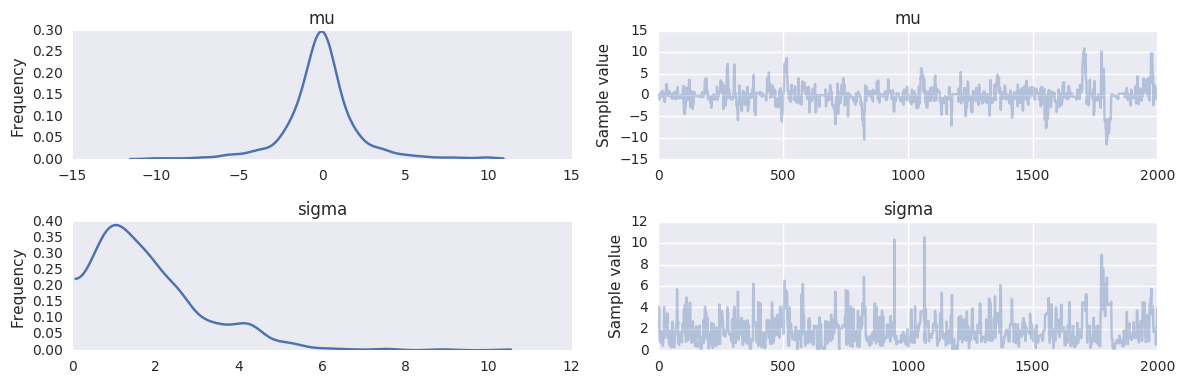

In [27]:
pm.traceplot(trace, varnames=['mu', 'sigma'])
pass

## Univariate normal distribution

In [28]:
xs = rng.normal(loc=5, scale=2, size=100)

/opt/conda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


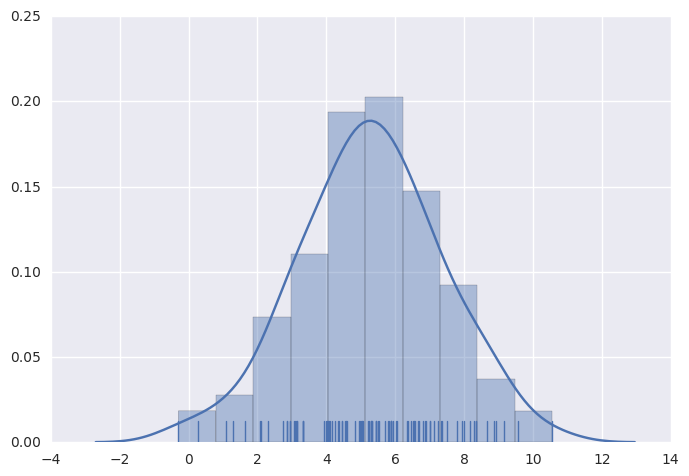

In [29]:
sns.distplot(xs, rug=True)
pass

## Sampling from posterior

In [30]:
niter = 2000
with pm.Model() as normal_context:
    mu = pm.Normal('mu', mu=0, sd=100)
    sd = pm.HalfCauchy('sd', beta=2)
    y = pm.Normal('y', mu=mu, sd=sd, observed=xs)
    trace = pm.sample(niter)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -223.18: 100%|██████████| 200000/200000 [00:19<00:00, 10185.34it/s]
Finished [100%]: Average ELBO = -223.18
100%|██████████| 2000/2000 [00:02<00:00, 847.15it/s] 


#### Find Highest Posterior Density (Credible intervals)

In [31]:
hpd = pm.stats.hpd(trace, alpha=0.05)
hpd

{'mu': array([ 4.87008876,  5.68313862]),
 'sd': array([ 1.80810522,  2.38210096]),
 'sd_log_': array([ 0.59227946,  0.86798286])}

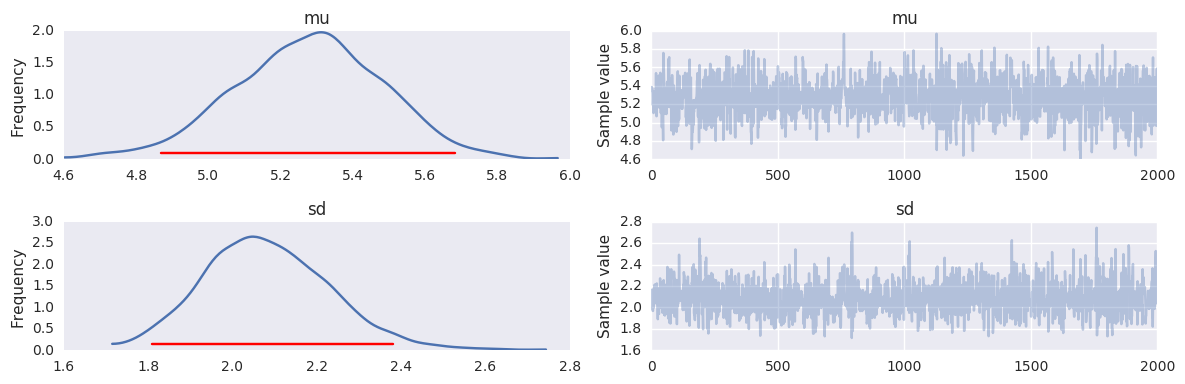

In [32]:
ax = pm.traceplot(trace, varnames=['mu', 'sd'],)

ymin, ymax = ax[0,0].get_ylim()
y = ymin + 0.05*(ymax-ymin)
ax[0, 0].plot(hpd['mu'], [y,y], c='red')

ymin, ymax = ax[1,0].get_ylim()
y = ymin + 0.05*(ymax-ymin)
ax[1, 0].plot(hpd['sd'], [y,y], c='red')
pass

## Evaluating goodness-of-fit

DIC, WAIC and BPIC are approximations to the out-of-sample error and can be used for model comparison. Likelihood is dependent on model complexity and should not be used for model comparisons.

In [33]:
post_mean = pm.df_summary(trace, varnames=trace.varnames)['mean'].to_dict()
post_mean

{'mu': 5.2774425669706622,
 'sd': 2.083811018098618,
 'sd_log_': 0.73163253719625909}

#### Likelihood

In [34]:
normal_context.logp(post_mean)

array(-220.7824869198777)

#### DIC

In [35]:
with normal_context:
    print(pm.stats.dic(trace))

445.508693887


#### WAIC

In [36]:
with normal_context:
    print(pm.stats.waic(trace))

(432.18295932008124, 14.386599474961665)


#### BPIC

In [37]:
with normal_context:
    print(pm.stats.bpic(trace))

447.480553911


-----

## Linear regression


We will show how to estimate regression parameters using a simple linear model

$$
y \sim ax + b
$$

We can restate the linear model $$y = ax + b + \epsilon$$ as sampling from a probability distribution

$$
y \sim \mathcal{N}(ax + b, \sigma^2)
$$

Now we can use `pymc` to estimate the parameters $a$, $b$ and $\sigma$. We will assume the following priors

$$
a \sim \mathcal{N}(0, 100) \\
b \sim \mathcal{N}(0, 100) \\
\sigma \sim | \mathcal{N(0, 1)} |
$$

#### Plate diagram

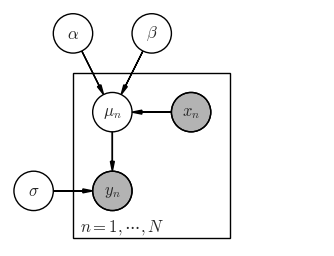

In [38]:
import daft

# Instantiate the PGM.
pgm = daft.PGM(shape=[4.0, 3.0], origin=[-0.3, -0.7])

# Hierarchical parameters.
pgm.add_node(daft.Node("alpha", r"$\alpha$", 0.5, 2))
pgm.add_node(daft.Node("beta", r"$\beta$", 1.5, 2))
pgm.add_node(daft.Node("sigma", r"$\sigma$", 0, 0))

# Deterministic variable.
pgm.add_node(daft.Node("mu", r"$\mu_n$", 1, 1))

# Data.
pgm.add_node(daft.Node("x", r"$x_n$", 2, 1, observed=True))
pgm.add_node(daft.Node("y", r"$y_n$", 1, 0, observed=True))

# Add in the edges.
pgm.add_edge("alpha", "mu")
pgm.add_edge("beta", "mu")
pgm.add_edge("x", "mu")
pgm.add_edge("mu", "y")
pgm.add_edge("sigma", "y")

# And a plate.
pgm.add_plate(daft.Plate([0.5, -0.5, 2, 2], label=r"$n = 1, \cdots, N$",
    shift=-0.1))

# Render and save.
pgm.render()
pgm.figure.savefig("lm.pdf")

#### Setting up and fitting linear model

In [39]:
# observed data
np.random.seed(123)
n = 11
_a = 6
_b = 2
x = np.linspace(0, 1, n)
y = _a*x + _b + np.random.randn(n)

In [40]:
niter = 10000
with pm.Model() as linreg:
    a = pm.Normal('a', mu=0, sd=100)
    b = pm.Normal('b', mu=0, sd=100)
    sigma = pm.HalfNormal('sigma', sd=1)
    
    y_est = a*x + b     
    likelihood = pm.Normal('y', mu=y_est, sd=sigma, observed=y)

    trace = pm.sample(niter, random_seed=123)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -29.675: 100%|██████████| 200000/200000 [00:20<00:00, 9819.42it/s]
Finished [100%]: Average ELBO = -29.672
100%|██████████| 10000/10000 [00:16<00:00, 590.17it/s]


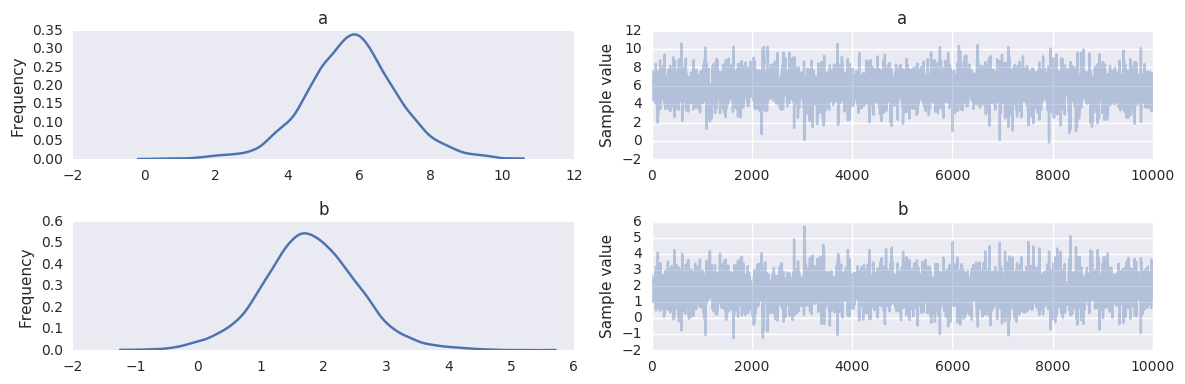

In [41]:
t = trace[niter//2:]
pm.traceplot(trace, varnames=['a', 'b'])
pass

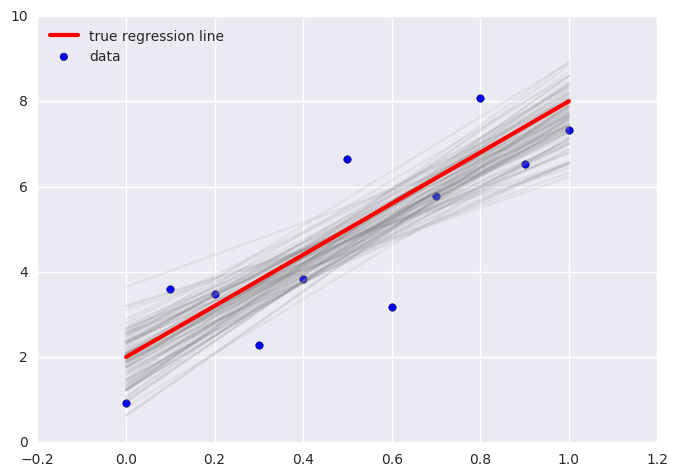

In [42]:
plt.scatter(x, y, s=30, label='data')
for a_, b_ in zip(t['a'][-100:], t['b'][-100:]):
    plt.plot(x, a_*x + b_, c='gray', alpha=0.1)
plt.plot(x, _a*x + _b, label='true regression line', lw=3., c='red')
plt.legend(loc='best')
pass

#### Posterior predictive checks

In [43]:
ppc = pm.sample_ppc(trace, samples=500, model=linreg, size=11)

100%|██████████| 500/500 [00:05<00:00, 87.95it/s]


/opt/conda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


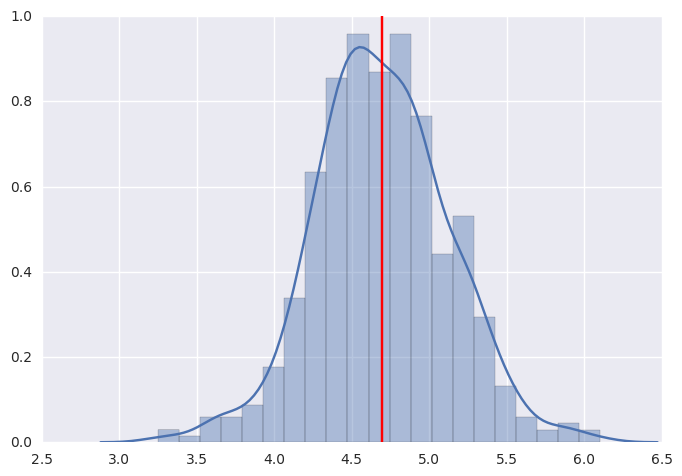

In [44]:
sns.distplot([np.mean(n) for n in ppc['y']], kde=True)
plt.axvline(np.mean(y), color='red')
pass

## Using the GLM module

In [45]:
df = pd.DataFrame({'x': x, 'y': y})
df.head()

,x,y
0,0.0,0.914369
1,0.1,3.597345
2,0.2,3.482978
3,0.3,2.293705
4,0.4,3.821400


In [46]:
with pm.Model() as model:
    pm.glm.glm('y ~ x', df)
    trace = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -49.658: 100%|██████████| 200000/200000 [00:25<00:00, 7767.70it/s]
Finished [100%]: Average ELBO = -49.655
100%|██████████| 2000/2000 [00:06<00:00, 321.26it/s]


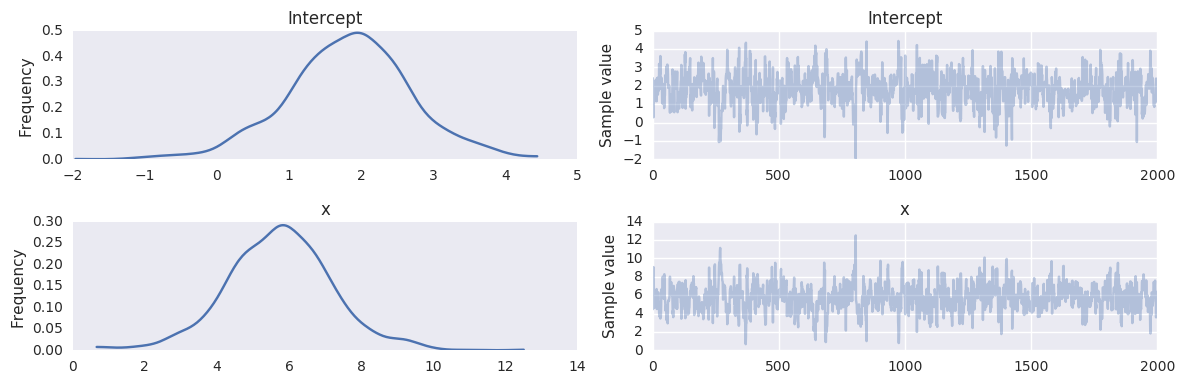

In [47]:
pm.traceplot(trace, varnames=['Intercept', 'x'])
pass

## Robust linear regression

In [48]:
# observed data
np.random.seed(123)
n = 11
_a = 6
_b = 2
x = np.linspace(0, 1, n)
y = _a*x + _b + np.random.randn(n)
y[5] *=10
df = pd.DataFrame({'x': x, 'y': y})
df.head()

,x,y
0,0.0,0.914369
1,0.1,3.597345
2,0.2,3.482978
3,0.3,2.293705
4,0.4,3.821400


#### Scale the data

In [49]:
x, y = StandardScaler().fit_transform(df[['x', 'y']]).T

#### Effect of outlier

In [50]:
niter = 10000
with pm.Model() as linreg:
    a = pm.Normal('a', mu=0, sd=100)
    b = pm.Normal('b', mu=0, sd=100)
    sigma = pm.HalfNormal('sigma', sd=1)
    
    y_est = a*x + b     
    y_obs = pm.Normal('y_obs', mu=y_est, sd=sigma, observed=y)

    trace = pm.sample(niter, random_seed=123)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -28.536: 100%|██████████| 200000/200000 [00:20<00:00, 9643.07it/s] 
Finished [100%]: Average ELBO = -28.523
100%|██████████| 10000/10000 [00:11<00:00, 838.53it/s]


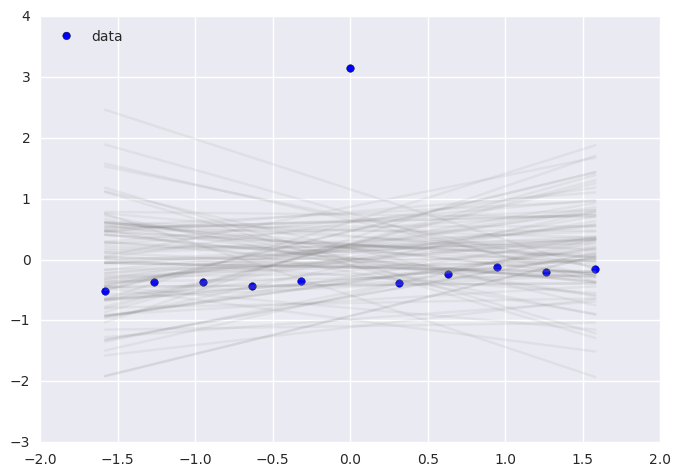

In [51]:
t = trace[niter//2:]
plt.scatter(x, y, s=30, label='data')
for a_, b_ in zip(t['a'][-100:], t['b'][-100:]):
    plt.plot(x, a_*x + b_, c='gray', alpha=0.1)
plt.legend(loc='upper left')
pass

#### Use a T-distribution for the errors for a more robust fit

In [52]:
niter = 10000
with pm.Model() as robust_linreg:
    beta = pm.Normal('beta', 0, 10, shape=2)
    nu = pm.Exponential('nu', 1/len(x))
    sigma = pm.HalfCauchy('sigma', beta=1)

    y_est = beta[0] + beta[1]*x
    y_obs = pm.StudentT('y_obs', mu=y_est, sd=sigma, nu=nu, observed=y)

    trace = pm.sample(niter, random_seed=123)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -12.964: 100%|██████████| 200000/200000 [00:33<00:00, 5908.80it/s]
Finished [100%]: Average ELBO = -12.963
100%|██████████| 10000/10000 [00:22<00:00, 451.48it/s]


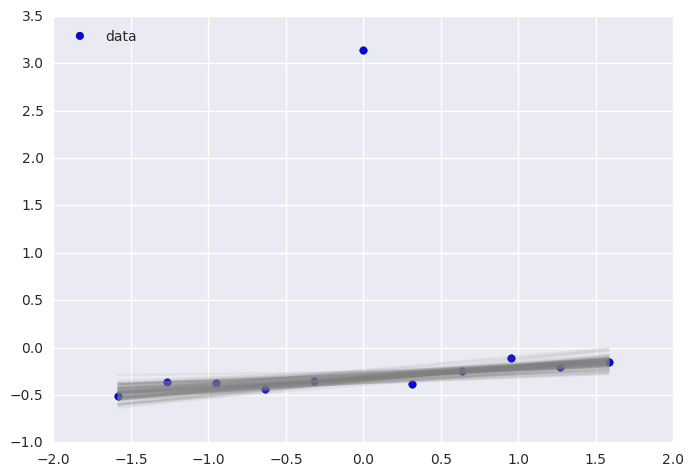

In [53]:
t = trace[niter//2:]
plt.scatter(x, y, s=30, label='data')
for a_, b_ in zip(t['beta'][-100:, 1], t['beta'][-100:, 0]):
    plt.plot(x, a_*x + b_, c='gray', alpha=0.1)
plt.legend(loc='upper left')
pass

## Logistic regression

We will look at the effect of strongly correlated variabels using a data set from Kruschke's book.

In [54]:
df = pd.read_csv('HtWt.csv')
df.head()

,male,height,weight
0,0,63.2,168.7
1,0,68.7,169.8
2,0,64.8,176.6
3,0,67.9,246.8
4,1,68.9,151.6


In [55]:
niter = 1000
with pm.Model() as model:
    pm.glm.glm('male ~ height + weight', df, family=pm.glm.families.Binomial()) 
    trace = pm.sample(niter, njobs=4, random_seed=123)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -96.159: 100%|██████████| 200000/200000 [00:26<00:00, 7659.27it/s]
Finished [100%]: Average ELBO = -95.563
100%|██████████| 1000/1000 [00:49<00:00, 20.14it/s]


#### Note poor convergence due to correlation between height and weight

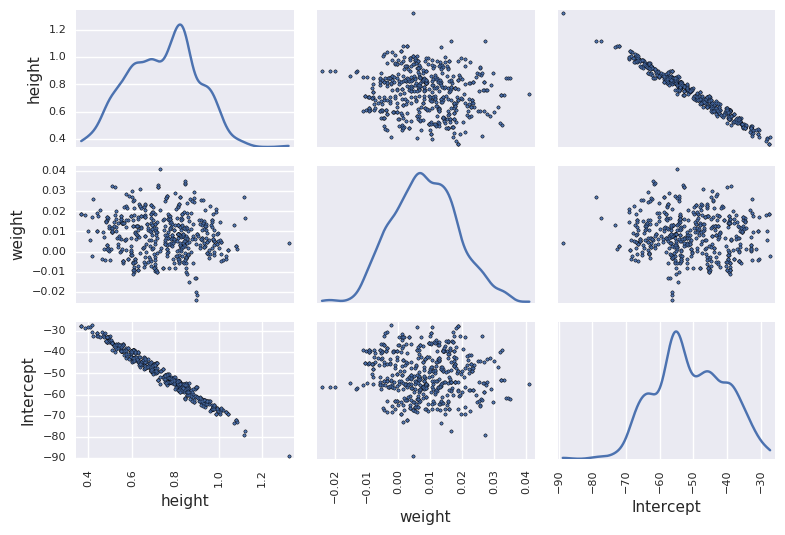

In [56]:
df_trace = pm.trace_to_dataframe(trace[niter//2:])
pd.scatter_matrix(df_trace.ix[-niter//2:, ['height', 'weight', 'Intercept']], diagonal='kde')
plt.tight_layout()
pass

#### Hamiltonian Monte Carlo is faster and converges better

In [57]:
niter = 1000
with pm.Model() as model:
    pm.glm.glm('male ~ height + weight', df, family=pm.glm.families.Binomial()) 
    trace = pm.sample(niter, njobs=4, random_seed=123)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -96.161: 100%|██████████| 200000/200000 [00:27<00:00, 7353.06it/s]
Finished [100%]: Average ELBO = -95.552
100%|██████████| 1000/1000 [00:53<00:00, 18.65it/s]


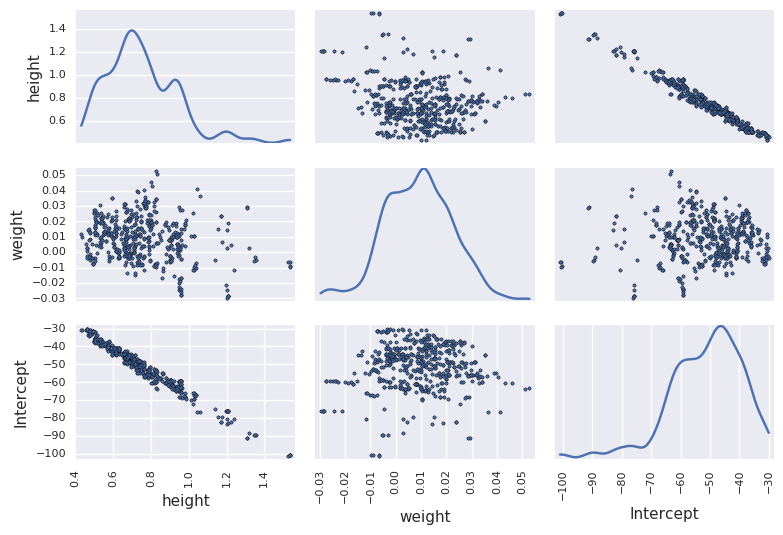

In [58]:
df_trace = pm.trace_to_dataframe(trace[niter//2:])
pd.scatter_matrix(df_trace.ix[-niter//2:, ['height', 'weight', 'Intercept']], diagonal='kde')
plt.tight_layout()
pass

## Logistic regression for classification

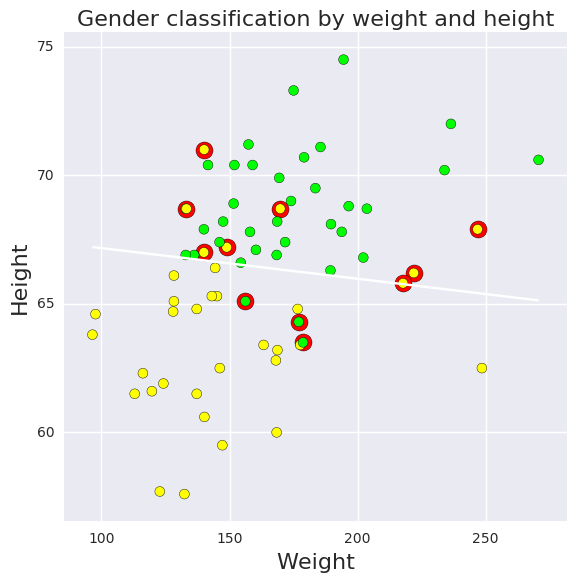

In [59]:
height, weight, intercept = df_trace[['height', 'weight', 'Intercept']].mean(0)

def predict(w, h, intercept=intercept, height=height, weight=weight):
    """Predict gender given weight (w) and height (h) values."""
    v = intercept + height*h + weight*w
    return np.exp(v)/(1+np.exp(v))

# calculate predictions on grid
xs = np.linspace(df.weight.min(), df.weight.max(), 100)
ys = np.linspace(df.height.min(), df.height.max(), 100)
X, Y = np.meshgrid(xs, ys)
Z = predict(X, Y)

plt.figure(figsize=(6,6))
# plot 0.5 contour line - classify as male if above this line
plt.contour(X, Y, Z, levels=[0.5])

# classify all subjects
colors = ['lime' if i else 'yellow' for i in df.male]
ps = predict(df.weight, df.height)
errs = ((ps < 0.5) & df.male) |((ps >= 0.5) & (1-df.male))
plt.scatter(df.weight[errs], df.height[errs], facecolors='red', s=150)
plt.scatter(df.weight, df.height, facecolors=colors, edgecolors='k', s=50, alpha=1);
plt.xlabel('Weight', fontsize=16)
plt.ylabel('Height', fontsize=16)
plt.title('Gender classification by weight and height', fontsize=16)
plt.tight_layout();

## Estimating parameters of a logistic model

Gelman's book has an example where the dose of a drug may be affected to the number of rat deaths in an experiment.

| Dose (log g/ml) | # Rats | # Deaths |
|-----------------|--------|----------|
| -0.896          | 5      | 0        |
| -0.296          | 5      | 1        |
| -0.053          | 5      | 3        |
| 0.727           | 5      | 5        |

We will model the number of deaths as a random sample from a binomial distribution, where $n$ is the number of rats and $p$ the probability of a rat dying. We are given $n = 5$, but we believe that $p$ may be related to the drug dose $x$. As $x$ increases the number of rats dying seems to increase, and since $p$ is a probability, we use the following model:

$$
y \sim \text{Bin}(n, p) \\
\text{logit}(p) = \alpha + \beta x \\
\alpha \sim \mathcal{N}(0, 5) \\
\beta \sim \mathcal{N}(0, 10)
$$

where we set vague priors for $\alpha$ and $\beta$, the parameters for the logistic model.

#### Observed data

In [60]:
n = 5 * np.ones(4)
x = np.array([-0.896, -0.296, -0.053, 0.727])
y = np.array([0, 1, 3, 5])

In [61]:
def invlogit(x):
    return np.exp(x) / (1 + np.exp(x))

with pm.Model() as model:
    alpha = pm.Normal('alpha', mu=0, sd=5)
    beta = pm.Flat('beta')
    
    p = invlogit(alpha + beta*x)
    y_obs = pm.Binomial('y_obs', n=n, p=p, observed=y)
    
    trace = pm.sample(niter, random_seed=123)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -inf: 100%|██████████| 200000/200000 [00:15<00:00, 12530.06it/s]
Finished [100%]: Average ELBO = -inf
100%|██████████| 1000/1000 [00:05<00:00, 185.80it/s]


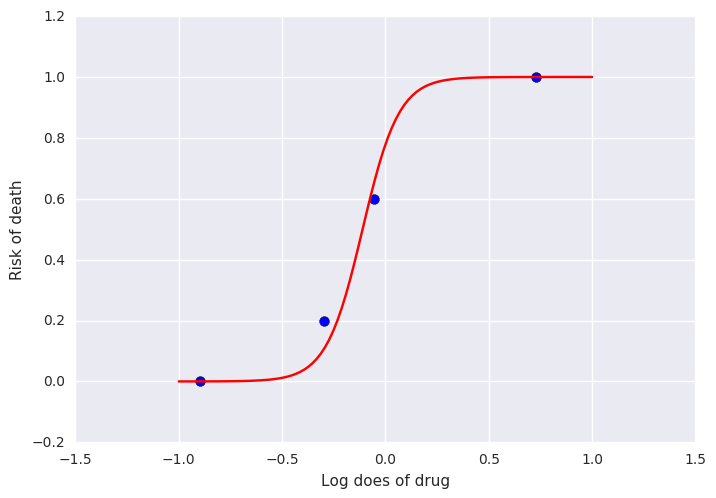

In [62]:
f = lambda a, b, xp: np.exp(a + b*xp)/(1 + np.exp(a + b*xp))

xp = np.linspace(-1, 1, 100)
a = trace.get_values('alpha').mean()
b = trace.get_values('beta').mean()
plt.plot(xp, f(a, b, xp), c='red')
plt.scatter(x, y/5, s=50);
plt.xlabel('Log does of drug')
plt.ylabel('Risk of death')
pass

## Hierarchical model

This uses the Gelman radon data set and is based off this [IPython notebook](http://twiecki.github.io/blog/2014/03/17/bayesian-glms-3/). Radon levels were measured in houses from all counties in several states. Here we want to know if the presence of a basement affects the level of radon, and if this is affected by which county the house is located in. 

![Radon](http://www.fix-your-radon.com/images/how_radon_enters.jpg)

The data set provided is just for the state of Minnesota, which has 85 counties with 2 to 116 measurements per county. We only need 3 columns for this example `county`, `log_radon`, `floor`, where `floor=0` indicates that there is a basement.

We will perform simple linear regression on log_radon as a function of county and floor.

In [63]:
radon = pd.read_csv('radon.csv')[['county', 'floor', 'log_radon']]
radon.head()

,county,floor,log_radon
0,AITKIN,1.0,0.832909
1,AITKIN,0.0,0.832909
2,AITKIN,0.0,1.098612
3,AITKIN,0.0,0.095310
4,ANOKA,0.0,1.163151


### Pooled model

In the pooled model, we ignore the county infomraiton.

$$
y \sim \mathcal{N}(a + bx, \sigma^2)
$$

where $y$ is the log radon level, and $x$ an indicator variable for whether there is a basement or not.

We make up some choices for the fairly uniformative priors as usual

$$
a \sim \mathcal{N}(\mu, \sigma_a^2) \\
b \sim \mathcal{N}(\mu, \sigma_b^2) \\
\sigma \sim \text{Gamma(10, 1)}
$$

However, since the radon level varies by geographical location, it might make sense to include county information in the model. One way to do this is to build a separate regression model for each county, but the sample sizes for some counties may be too small for precise estimates. A compromise between the pooled and separate county models is to use a hierarchical model for *patial pooling* - the practical efffect of this is to shrink per county estimates towards the group mean, especially for counties with few observations.

#### Hierarchical model

With a hierarchical model, there is an $a_c$ and a $b_c$ for each county $c$ just as in the individual county model, but they are no longer independent but assumed to come from a common group distribution

$$
a_c \sim \mathcal{N}(\mu_a, \sigma_a^2) \\
b_c \sim \mathcal{N}(\mu_b, \sigma_b^2)
$$

we further assume that the hyperparameters come from the following distributions

$$
\mu_a \sim \mathcal{N}(0, 10^2) \\
\sigma_a \sim \text{|Cauchy(1)|} \\ 
\mu_b \sim \mathcal{N}(0, 10^2) \\
\sigma_b \sim \text{|Cauchy(1)|} \\ 
$$

The variance for observations does not change, so the model for the radon level is

$$
y \sim \mathcal{N}(a_c + b_c x, \sigma^2)
$$

In [64]:
county = pd.Categorical(radon['county']).codes

niter = 1000
with pm.Model() as hm:
    # County hyperpriors
    mu_a = pm.Normal('mu_a', mu=0, sd=10)
    sigma_a = pm.HalfCauchy('sigma_a', beta=1)
    mu_b = pm.Normal('mu_b', mu=0, sd=10)
    sigma_b = pm.HalfCauchy('sigma_b', beta=1)
    
    # County slopes and intercepts
    a = pm.Normal('slope', mu=mu_a, sd=sigma_a, shape=len(set(county)))
    b = pm.Normal('intercept', mu=mu_b, sd=sigma_b, shape=len(set(county)))
    
    # Houseehold errors
    sigma = pm.Gamma("sigma", alpha=10, beta=1)
    
    # Model prediction of radon level
    mu = a[county] + b[county] * radon.floor.values
    
    # Data likelihood
    y = pm.Normal('y', mu=mu, sd=sigma, observed=radon.log_radon)

    hm_trace = pm.sample(niter)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -1,087.9: 100%|██████████| 200000/200000 [00:55<00:00, 3635.46it/s]
Finished [100%]: Average ELBO = -1,088.2
100%|██████████| 1000/1000 [00:23<00:00, 42.18it/s]


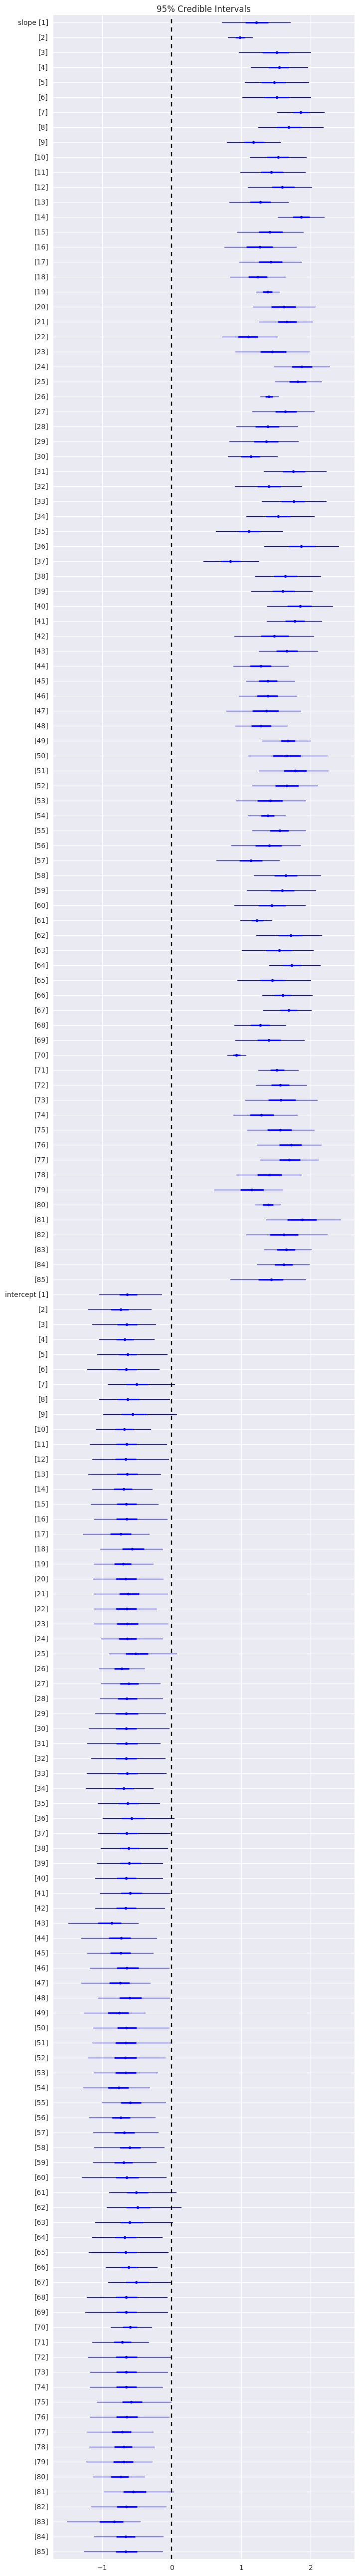

In [65]:
plt.figure(figsize=(8, 60))
pm.forestplot(hm_trace, varnames=['slope', 'intercept'])
pass

## Gaussian Mixture Model

In [66]:
from theano.compile.ops import  as_op
import theano.tensor as T

In [67]:
np.random.seed(1)
y = np.r_[np.random.normal(-6, 2, 500), 
          np.random.normal(0, 1, 200), 
          np.random.normal(4, 1, 300)]
n = y.shape[0]

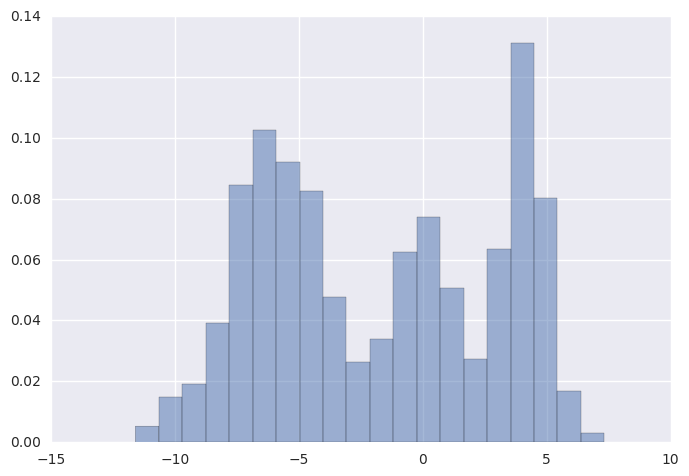

In [68]:
plt.hist(y, bins=20, normed=True, alpha=0.5)
pass

In [69]:
k = 3
niter = 1000
with pm.Model() as gmm:
    p = pm.Dirichlet('p', np.ones(k), shape=k)
    mus = pm.Normal('mus', mu=[0, 0, 0], sd=15, shape=k)
    sds = pm.HalfNormal('sds', sd=5, shape=k)
        
    Y_obs = pm.NormalMixture('Y_obs', p, mus, sd=sds, observed=y)
    trace = pm.sample(niter)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -8,888.4: 100%|██████████| 200000/200000 [01:43<00:00, 1927.51it/s]
Finished [100%]: Average ELBO = -8,888.5
100%|██████████| 1000/1000 [08:55<00:00,  3.19it/s]


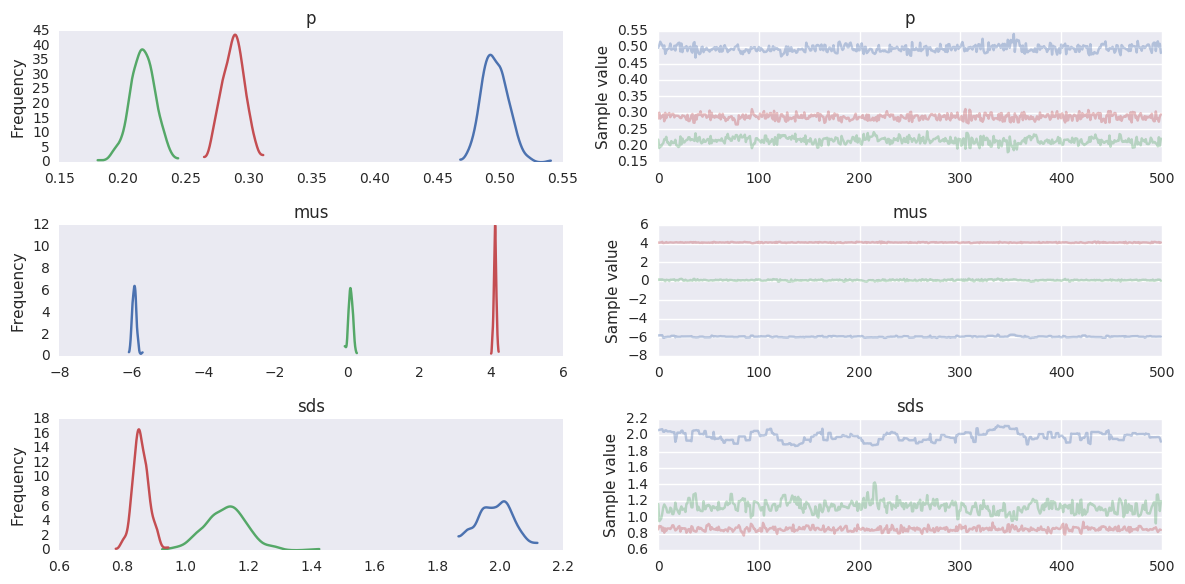

In [70]:
burn = niter//2
trace = trace[burn:]
pm.traceplot(trace, varnames=['p', 'mus', 'sds'])
pass